# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors
from functools import partial

from IPython.display import clear_output
from ocp import ILQR
from costs import *
import pdb
from utils import subsample

from scipy.optimize import fmin



np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

In [2]:
from ocp import *

In [3]:
%matplotlib inline

## Part 1: Standard Controller 

#### Try solving and analyse result

In [4]:
%matplotlib qt

biped = Biped()

#standard values with standard params
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

#standard values with already stable limit cycle
# q0, dq0 = (np.array([-0.3035,  0.3608,  0.2487]), np.array([ 0.8319, -1.1396,  4.6439]))
# qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
# T = int(0.375/biped.dT)

# #standard values with already (almost) stable limit cycle for ilqr
q0, dq0 = (np.array([-0.3075,  0.3459,  0.2666]), np.array([ 0.8131, -1.1405,  5.0078]))
qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
#(array([-0.3025,  0.3241,  0.233 ]), array([ 0.8955, -1.4391,  4.6021]))
#(array([-0.3038,  0.3368,  0.2396]), array([ 0.8731, -1.3125,  4.6623]))
T = int(0.375/biped.dT)

sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)
clear_output()

#biped.animate(sln, dt = 0.001)

res = biped.analyse(sln, biped.control_parameters, to_plot=True)

COT: 1812.70, Dist: 0.326, dT: 0.375


In [6]:
xs_std, us_std = np.hstack([res['qs'], res['dqs']]), res['us']

In [7]:
ddqs_std = np.array(np.gradient(xs_std, axis=0))[:,3:]

#### Try optimizing

In [8]:
def opt_func(opt_parameters, num_steps):
    print(num_steps)
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    x = opt_parameters[6:]

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, x);
    results = biped.analyse(sln, x, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    effort = results['effort']
    distance = np.sum(results['ds'])
    frequency = (results['fs'][-1])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    w1, w2, vd = .1, 0.1, 1.
    objective_value = w1*abs(vd - velocity) + w2*CoT
    #objective_value = -np.mean(results['ds']) #+ 0.0001*CoT

    if distance < 0 or CoT < 0 or velocity < 0:
        objective_value = 1000        
    print(objective_value)
    print(opt_parameters)
    return objective_value

### Observe the resulting initial and final configs

## Part 2: Using iLQR

### One step motion using standard controller

In [173]:
x0 = np.concatenate([q0, dq0])
xT = np.concatenate([qT, dqT])
xs_init, us_init, z_swfs_init, dist_init = biped.compute_control_standard(x0, T, biped.control_parameters)

effort_init = np.sum(us_init[:,0]**2 + us_init[:,1]**2)/(2*T*biped.dT*30)
cot_init = effort_init / dist_init
print(effort_init, cot_init)

(4329.984905114607, 15485.981491199867)


### Formulate the iLQR problem

In [174]:
Tc = T
x_ref = xT.copy()
biped.set_init_state(x0)

#### Define cost

In [175]:
Tc = 375

In [176]:
x_ref[2] = 0.1
#standard cost on state and control
Q = np.diag([0,0,1,0,0,0])*100
Qf = np.diag([0,0,100,0,0,0])*1
R = np.eye(biped.Du)*.01

#swing trajectory
Wt = np.diag([0, 1e4])
z_refs = np.linspace(0.01, -0.01, Tc)

#swing foot final position
WT = np.diag([1e3, 1e4])
p_ref = np.array([0.31, -0.01])

#velocity of hip
Wv = np.diag([1e3,1e3])*0
v_ref = np.array([.8, 0])

costs = []
for i in range(Tc):
    if i < Tc/3:
        runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
    else:
        runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
        
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    
    if i > Tc/2:
        runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    else:
        runningEECost = CostModelQuadraticTranslation(biped, 1*Wt, p_ref = p_ref_t)
        
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost,terminalEEVelCost ])
costs += [terminalCost]

#### Define iLQR

In [177]:
ilqr = ILQR(biped)
ilqr.set_init_state(x0)
ilqr.set_timestep(Tc)
ilqr.set_cost(costs)

#### Initialization

In [178]:
init_types = ['control_std', 'inv_dyn', 'zeros']
init_type = 1
if init_type == 0:
    xs_init, us_init,_,_ = biped.compute_control_standard(x0, Tc, biped.control_parameters)
elif init_type == 1:
    xs_init = np.array([x0]*(Tc+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((Tc+1, 3))))
    biped.set_init_state(x0)
    #xs_init = biped.rollout(us_init)
elif init_type == 2:
    us_init = np.zeros((Tc+1, biped.Du))
    biped.set_init_state(x0)
    xs_init = biped.rollout(us_init[:-1])
    
%matplotlib qt 
#biped.animate_ys(xs_init)

In [179]:
ilqr.set_state(xs_init, us_init)
ilqr.solve(10)
clear_output()
xs_ilqr, us_ilqr = ilqr.xs, ilqr.us

ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis = 0))[:,3:]/biped.dT

In [180]:
x_swf, z_swf, _, _ = biped.kin_swf(xs_ilqr[-1][:3], xs_ilqr[-1][3:])
print(x_swf, z_swf)

(0.28533818398704996, -0.014949220640406324)


### Evaluate

#### Try simulation with ilqr

In [181]:
biped.set_control('ilqr', ilqr)

In [182]:
sln = biped.solve_eqns(q0, dq0,20, biped.control_parameters)
clear_output()

COT: 15837.55, Dist: 0.032, dT: 0.017


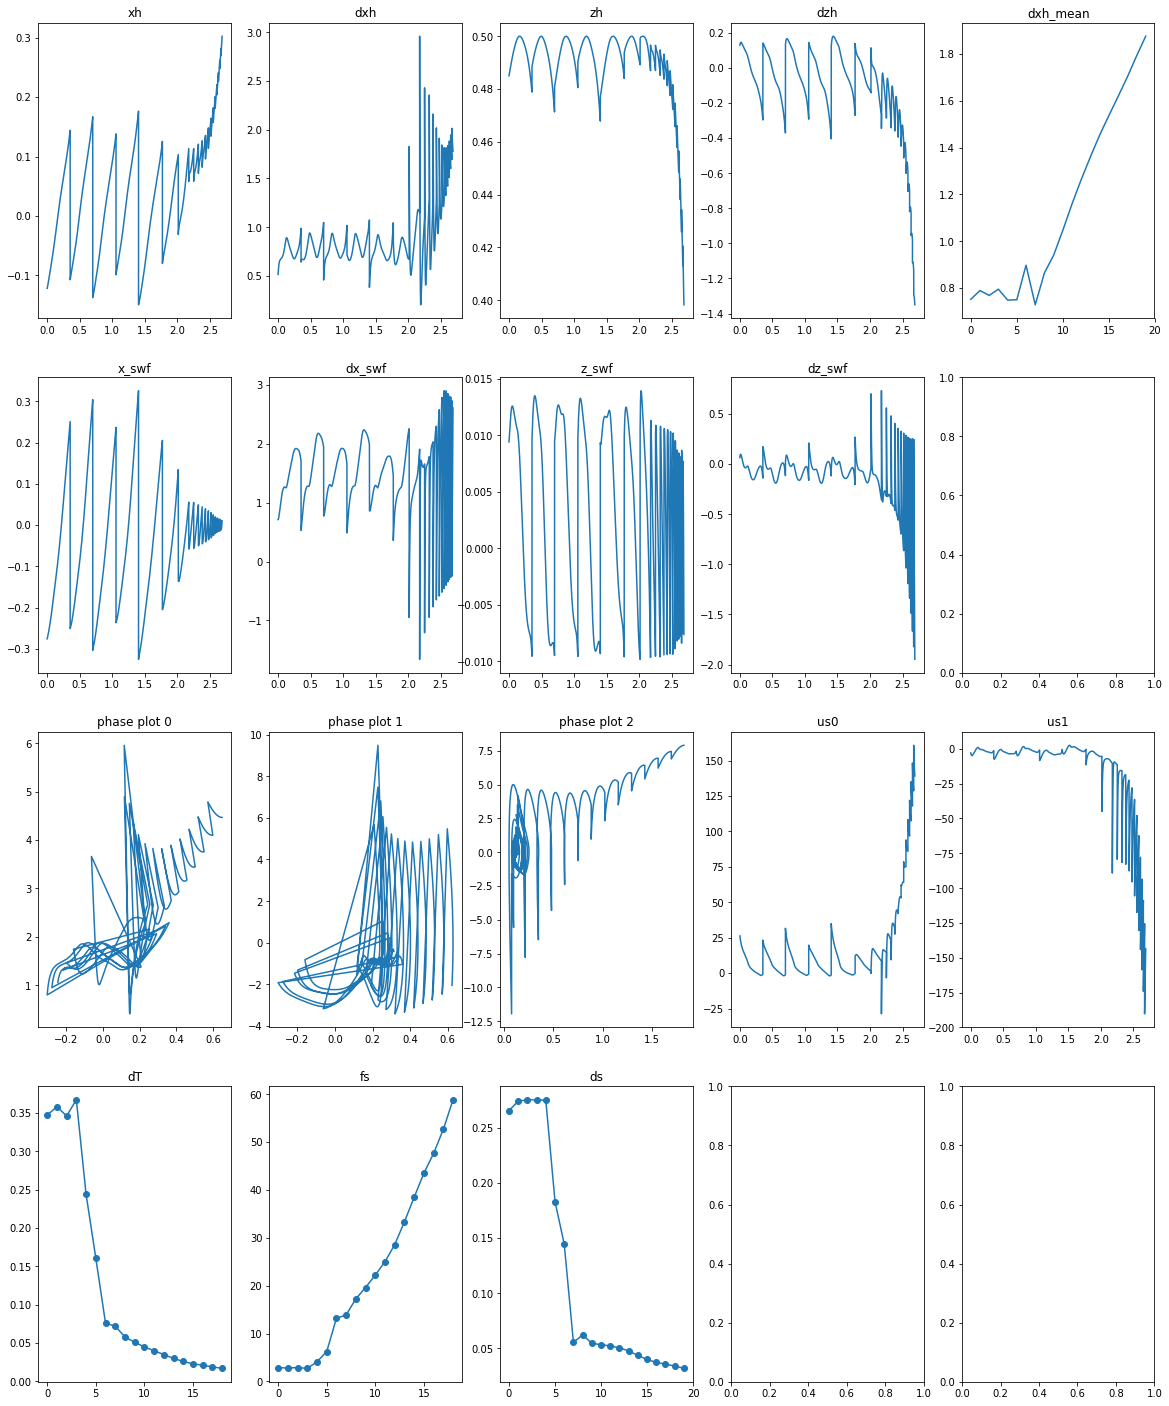

In [183]:
%matplotlib inline
_ = biped.analyse(sln, biped.control_parameters, True)

In [76]:
sln['Y'][-1].shape

(360, 6)

In [80]:
xs_ilqr = sln['Y'][-1]
ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis = 0))[:,3:]/biped.dT

In [87]:
x0 = xs_ilqr[0].copy()

## Use QP

In [9]:
import quadprog

def compute_qp(biped, y, yd, Kp = 100*np.eye(3), Kd = 100*np.eye(3), Q = 100*np.eye(3)):
    q, dq, qd, dqd = y[:3], y[3:], yd[:3], yd[3:]
    qdd = -Kp.dot(q-qd) - Kd.dot(dq-dqd)
    
    xd = np.concatenate([qdd, np.zeros(2)])
    Qt = np.eye(5)*1e-10
    Qt[:3,:3] = Q
    
    a = xd.T.dot(Qt)
    
    M = biped.eval_M(q)
    C = biped.eval_C(q,dq)
    G = biped.eval_G(q)
    B = biped.eval_B()
    
    Ct = np.hstack([M, -B]).T
    Et = np.zeros((5,4))
    Et[3,0] = 1
    Et[3,1] = -1
    Et[3,2] = 1
    Et[3,3] = -1
    Ct = np.hstack([Ct, Et])
    
    dt = -30*np.ones(4)
    bt = -C.dot(dq) - G
    bt = np.concatenate([bt, dt])
    #print(Qt)
    x = quadprog.solve_qp(Qt, a, Ct, bt, meq = 3)
    return x[0][-2:]
    

In [14]:
x0 = np.concatenate([q0, dq0])

In [16]:
biped.set_control('qp', None, xs_std, ddqs_std)

x = x0.copy()
xs = [x]
us = []
z_swfs = []
x_h0, _,_,_ = biped.kin_hip(x[:3])
for h in range(len(xs_std)-2):
    x_std = xs_std[h]
    ddq_d = ddqs_std[h]
    u = biped.compute_qp(x, x_std, ddq_d)
    x = biped.step(x, u)
    _,z_swf,_,_ = biped.kin_swf(x[:3])
    z_swfs += [z_swf]
    xs += [x]
    us += [u]
    
x_hT , _,dx_hT,dz_hT = biped.kin_hip(x[:3])
dist = x_hT-x_h0
xs = np.array(xs)
us = np.array(us)
z_swfs = np.array(z_swfs)

In [ ]:
%matplotlib qt

z_swfs = biped.animate_ys(xs)

%matplotlib inline

plt.plot(us[:,0])

idx = 0
plt.plot(xs[:,idx], 'r', label='qp')
plt.plot(xs_ilqr[:,idx], 'b', label='ilqr')

plt.figure()
plt.plot(z_swfs)

#### Evaluate

In [27]:
y0 = x0.copy()

In [28]:
def opt_func_qp(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    Kp = opt_parameters[0]*np.eye(3)
    Kd = opt_parameters[1]*np.eye(3)
    biped.set_control('qp', None, xs_std, ddqs_std, Kd = Kd, Kp = Kp, max_control = 60)
    
    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0)
    print('Objective: {}'.format(objective_value))
    print(y0, yn)
    return objective_value

In [33]:
#biped.set_control('ilqr', ilqr)

import time
tic = time.time()
opt_parameters0 = np.array([2.1, 10.5])
res = fmin(opt_func_qp, opt_parameters0, args = (2,), disp=1, full_output=True, maxiter = 100)
clear_output()
toc = time.time()
print(toc-tic)
print(res[1])

115.139306068
1.3727756825721944


In [163]:
q0, dq0 = x0[:3], x0[3:]

In [167]:
biped.set_control('qp', None, xs_ilqr, ddqs_ilqr, Kd = 2.0475*np.eye(3), Kp = 12.075*np.eye(3), max_control = 60)

In [34]:
sln = biped.solve_eqns(q0, dq0,10, biped.control_parameters)
clear_output()

COT: 21304.08, Dist: 0.045, dT: 0.022


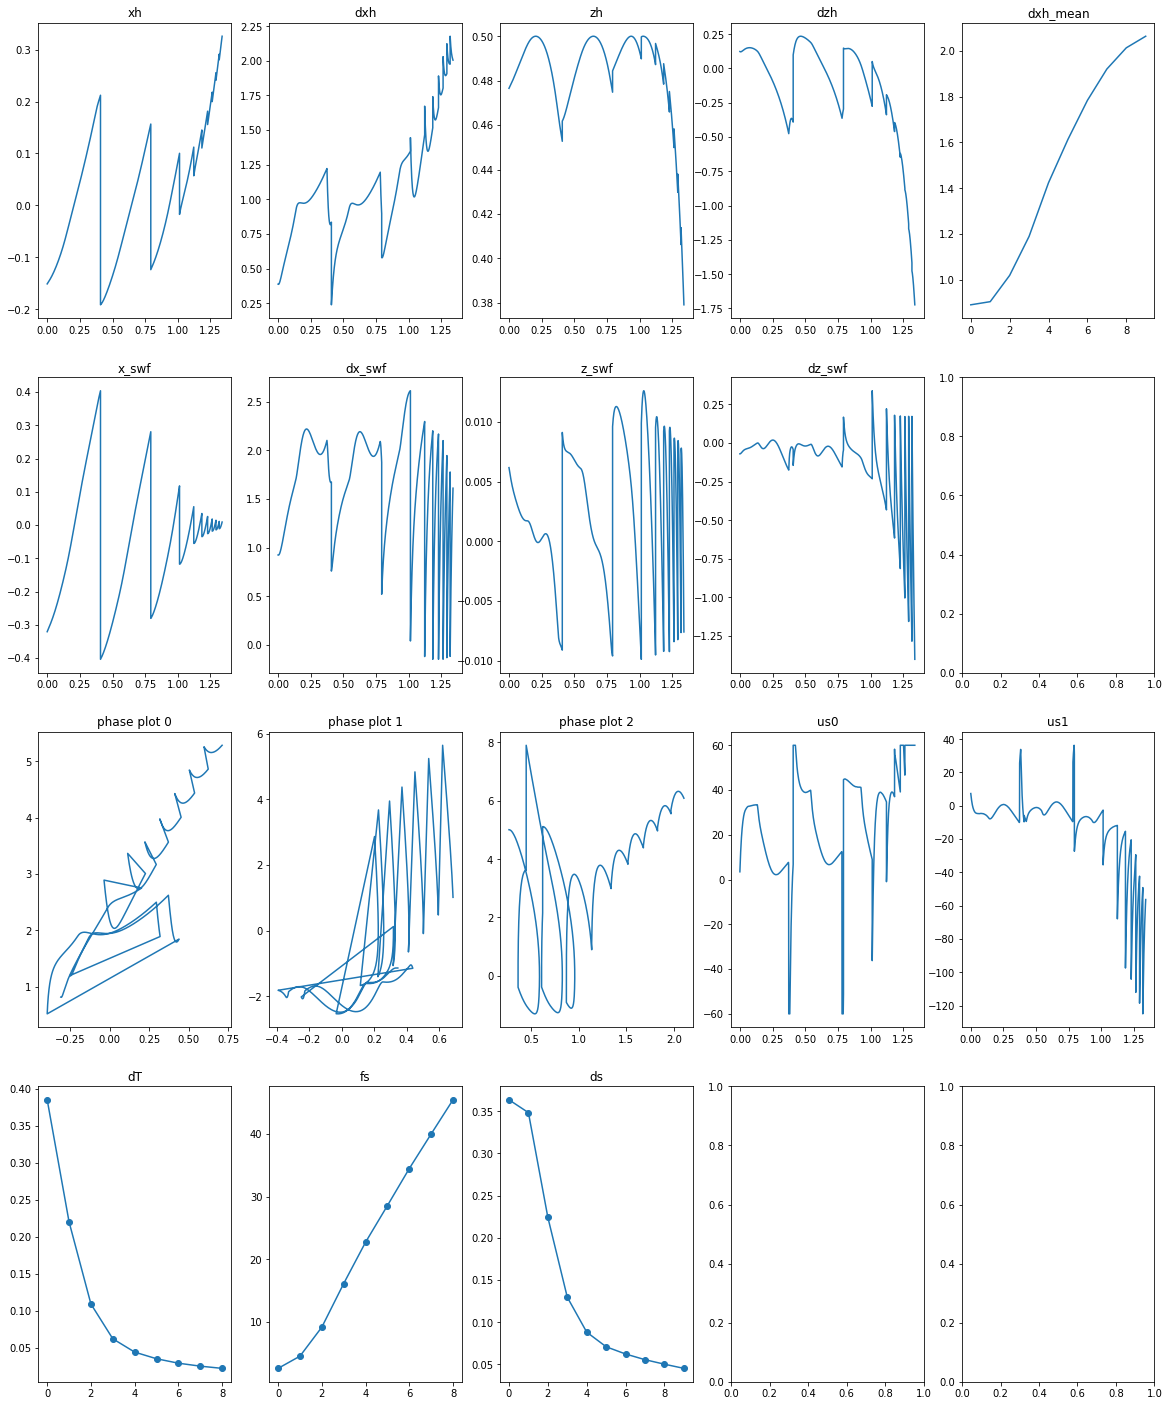

In [36]:
%matplotlib inline
ress = biped.analyse(sln, biped.control_parameters)
#xs_qp, us_qp = np.hstack([res['qs'], res['dqs']]), res['us']

Real time factor:0.312281509973


0.31228150997255477

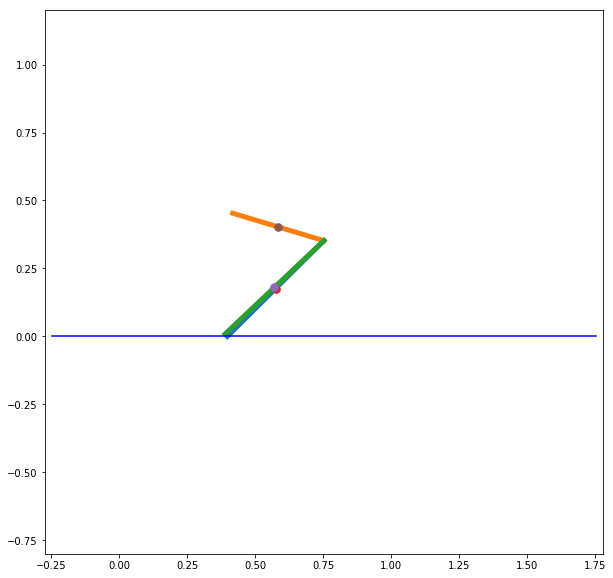

In [170]:
%matplotlib qt 
biped.animate(sln)

## Try optimizing

In [20]:
def opt_func_ilqr(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    y0 = np.concatenate([q0, dq0])
    #Tc = opt_parameters[6]
    #alpha = 
    #step_length = 
    #
    
    #define ilqr
    ### Formulate the iLQR problem
    Tc = 375
    x_ref = np.array([0,0,0.1,0,0,0])
    biped.set_init_state(y0.copy())

    #### Define cost
    #standard cost on state and control
    Q = np.diag([0,0,1,0,0,0])*100
    Qf = np.diag([0,0,100,0,0,0])*1
    R = np.eye(biped.Du)*.01

    #swing trajectory
    Wt = np.diag([0, 1e4])
    z_refs = np.linspace(0.01, -0.01, Tc)

    #swing foot final position
    WT = np.diag([1e3, 1e4])
    p_ref = np.array([0.31, -0.01])

    #velocity of hip
    Wv = np.diag([1e3,1e3])*0
    v_ref = np.array([.8, 0])

    costs = []
    for i in range(Tc):
        if i < 2:
            runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
        else:
            runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)

        runningControlCostShort = CostModelQuadratic(biped, None, R)
        p_ref_t = np.array([0, z_refs[i]])

        if i > Tc/2:
            runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
        else:
            runningEECost = CostModelQuadraticTranslation(biped, 1*Wt, p_ref = p_ref_t)

        runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
        costs += [runningCostShort]
    terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
    terminalControlCost = CostModelQuadratic(biped, None,R)
    terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
    terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
    terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost,terminalEEVelCost ])
    costs += [terminalCost]

    #### Define iLQR

    ilqr = ILQR(biped)
    ilqr.set_init_state(y0)
    ilqr.set_timestep(Tc)
    ilqr.set_cost(costs)
    
    biped.set_control('ilqr', ilqr)
    
    #train ilqr
    biped.ilqr.set_init_state(y0.copy())
    biped.set_init_state(y0.copy())
    #params = biped.control_parameters.copy()
    #xs, us, _, _ = biped.compute_control_standard(y0, biped.ilqr.T, params)
    xs_init = np.array([y0]*(biped.ilqr.T+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((biped.ilqr.T+1, 3))))
     
    biped.ilqr.set_state(xs_init, us_init)
    biped.ilqr.solve(5)
    
    #biped.set_control('qp', biped.ilqr, biped.ilqr.xs)

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    max_actuation = 30;
    effort = results['effort']
    distance = np.sum(results['ds'])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    print('cot:{}'.format(CoT))
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]
    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0)
    print('Objective: {}'.format(objective_value))
    print(y0, yn)
    return objective_value

In [26]:
#biped.set_control('ilqr', ilqr)

import time
tic = time.time()
opt_parameters0 = np.concatenate([q0, dq0])
res = fmin(opt_func_ilqr, opt_parameters0, args = (3,), disp=1, full_output=True, maxiter = 30)
clear_output()
toc = time.time()
print(toc-tic)
print(res[1])

164.367150068
0.25274684381956414


In [29]:
q0, dq0

(array([-0.3038,  0.3368,  0.2396]), array([ 0.8731, -1.3125,  4.6623]))

#### Simulation using Optimized parameters

COT: 28530.10, Dist: 0.013, dT: 0.009


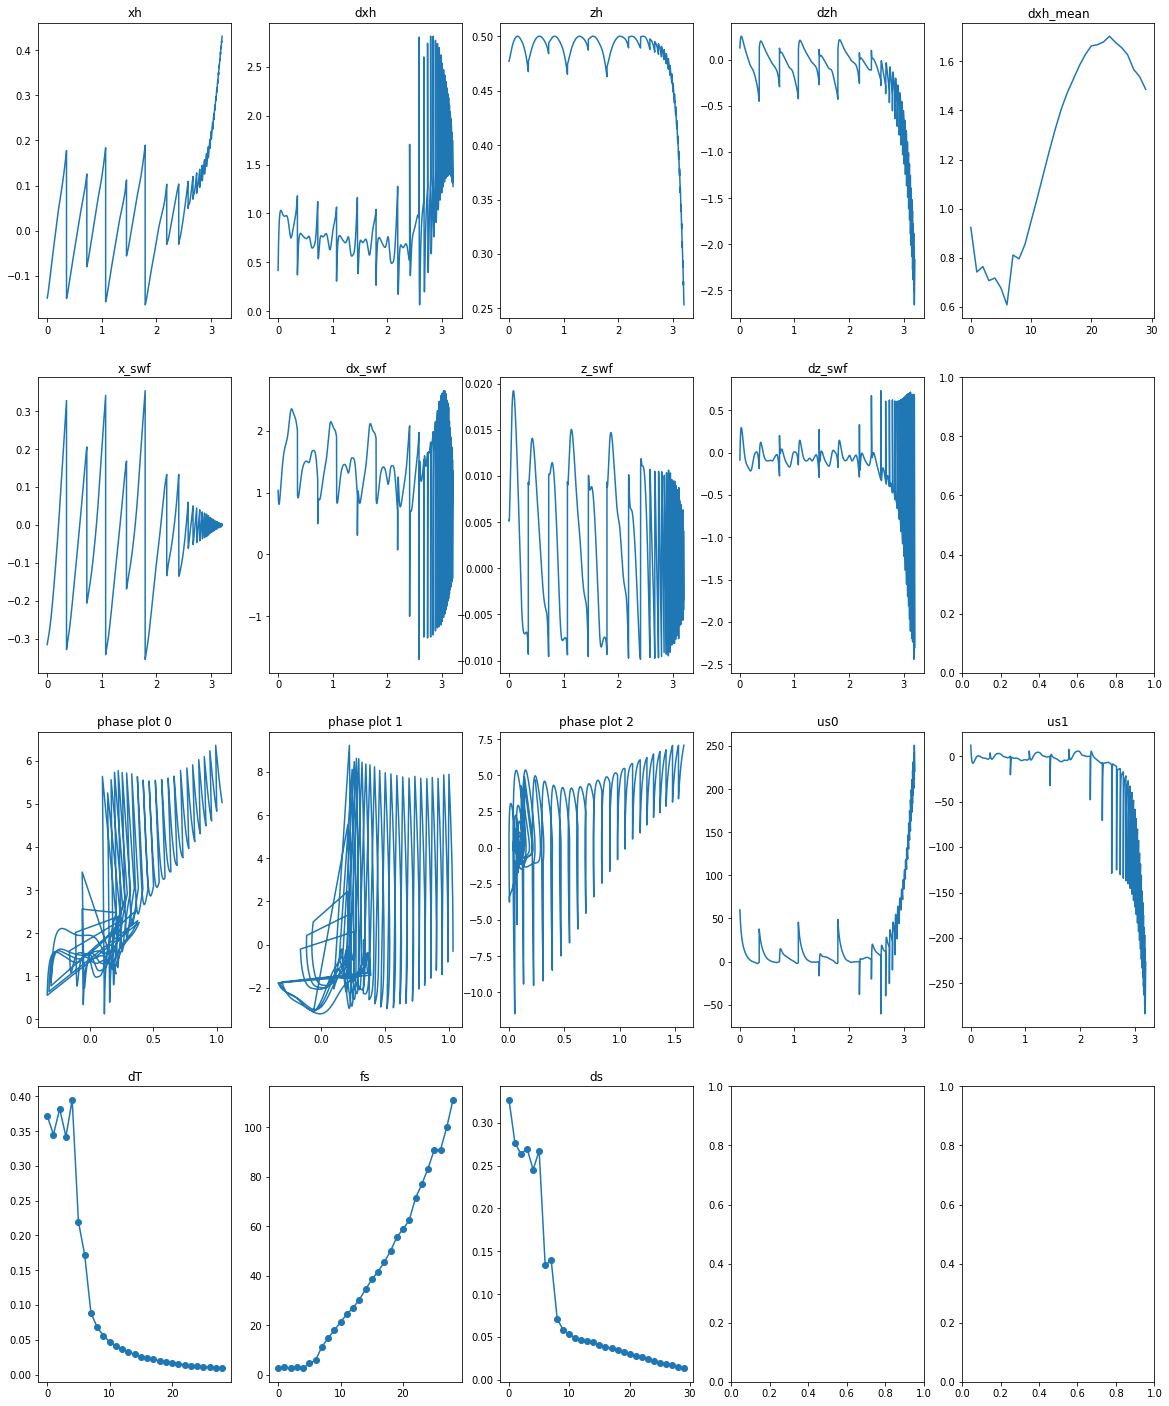

In [28]:
opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 30, params)
%matplotlib qt
clear_output()
#biped.animate(sln)
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)

In [25]:
%matplotlib qt
biped.animate(sln)

Real time factor:0.331969302107


0.33196930210655307

In [301]:
biped.set_control('qp', biped.ilqr, biped.ilqr.xs, Q = 1000*np.eye(3), Kd = 200*np.eye(3), Kp = 5000*np.eye(3), max_control=60)

#### Simulation using Optimized parameters

In [302]:
opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 10, params)
%matplotlib qt
clear_output()
biped.animate(sln)

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)
plt.savefig('d.png')

#### retrain the iLQR

#### Try simulation with ilqr

In [273]:
sln = biped.solve_eqns(q0, dq0,10, params, True)
clear_output()

biped.animate(sln)

res = biped.analyse(sln, params, False)

#### Compare against matlab